In [1]:
import numpy as np
import pandas as pd
import os
import re
import sys
from datetime import timedelta
from datetime import datetime
from fbprophet import Prophet
import pickle

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
def read_data_stromfluss(data_dir):
    """Read data from directory, get rid of '-' and NaN values, export a dataframe"""

    dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
    numberparse = lambda x: pd.np.float(x.replace(".", "").replace(",", ".")) if x != "-" else np.nan
    convert_thousand = {num: numberparse for num in np.arange(2, 22)}

    import_files = os.listdir(data_dir)

    for i in range(len(import_files)):
        if i == 0:
            df = pd.read_csv(os.path.join(data_dir, import_files[i]), sep=';', decimal=',', thousands='.',
                             parse_dates=['Datum'], date_parser=dateparse, converters=convert_thousand)
        else:
            df = df.append(pd.read_csv(os.path.join(data_dir, import_files[i]), sep=';', decimal=',', thousands='.',
                                       parse_dates=['Datum'], date_parser=dateparse, converters=convert_thousand))

    df.replace('-', 0, inplace=True)
    df.fillna(0, inplace=True)

    return df

def _create_datetime(row):
    """Helper Function

    Parameters
    ----------
    row : TYPE
        Description
    row : pd.Series

    Returns
    -------
    pd.Datetime
    """
    if("Datum" in row):
        date = row.Datum.strftime("%Y-%m-%d") + " " + row.Uhrzeit
        return date

def preprocessing_stromfluss(df, basic = False):
    """Preprocessing für stromfluss Datansatz von Smard

    Parameters
    ----------
    df : pd.DataFrame
        stromfluss Datensatz von SMARD eingelesen und unbearbeitet

    Returns
    -------
    pd.DataFrame
        stromfluss Datensatz von SMARD aufbereitet zur weiteren Verwendung
    """

    # Time Formatting
    df["Date"] = df.apply(lambda row: _create_datetime(row), axis=1)
    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d %H:%M")
    df = df.sort_values("Date")

    cols = list(df)
    cols.insert(0, cols.pop(cols.index("Date")))
    df = df.loc[:, cols]

    # Rename columns
    countries = {
        "Niederlande": "NL",
        "Schweiz": "CHE",
        "Dänemark": "DNK",
        "Tschechien": "CZE",
        "Luxemburg": "LUX",
        "Schweden": "SWE",
        "Österreich": "AUT",
        "Frankreich": "FRA",
        "Polen": "PL",
    }

    types = {"Import": "IM", "Export": "EX"}

    type_pattern = r"\((.*?)\)"
    country_pattern = r"(.*?) "

    df.columns = list(df.columns[0:3]) + ['NX'] + [countries.get(re.search(country_pattern, col).group(1))+ "_"+ types.get(re.search(type_pattern, col).group(1)) for col in df.columns[4::]]

    # Netto Export
    df["NX"] = df.iloc[:, 4:].sum(axis = 1)
    
    #Drop columns
    df.drop(df.columns[1:3], axis=1, inplace = True)

    #Export only Datetime and NX for basic analysis
    if basic:
        df = df[['Date', 'NX']]

    return df

def get_training_sets(df: object, training_window_width: int, evaluation_days: list)->list:
    '''
    Provides a list containing pairs of training and validation sets for time series forecasts such as ARIMA. Validation is always done on all hours of a single day.
    :param df: pandas.DataFrame containing the time series data
    :param training_window_width: training window width in days. window width stays fix over validations
    :param evaluation_days: list of days on which to perform validations
    :return: list of evaluation sets
    '''

    evaluation_sets = []

    # Split the dataframe in training and evaluation data
    for day in evaluation_days:
        training_data = df[(df.index.date >((day - timedelta(days=training_window_width)).date()) & df.index.date < day.date())]
        evaluation_data = df[df.index.date == day.date()]

        evaluation_sets.append({"training_data": training_data, "evaluation_data": evaluation_data})

    return evaluation_sets

In [3]:
df = read_data_stromfluss("../../data/stromfluss")
df = preprocessing_stromfluss(df)
#df=df.rename(index=str, columns={"Date":"ds", "NX":"y"})
df

,Date,NX,NL_EX,NL_IM,CHE_EX,CHE_IM,DNK_EX,DNK_IM,CZE_EX,CZE_IM,LUX_EX,LUX_IM,SWE_EX,SWE_IM,AUT_EX,AUT_IM,FRA_EX,FRA_IM,PL_EX,PL_IM
0,2015-06-01 00:00:00,7279.0,3932.0,-0.0,145.0,-0.0,113.0,-385.0,912.0,-358.0,0.0,0.0,1.0,-0.0,1394.0,-0.0,246.0,-0.0,1279.0,-0.0
1,2015-06-01 01:00:00,7167.0,4014.0,-0.0,261.0,-0.0,63.0,-204.0,839.0,-370.0,0.0,0.0,1.0,-0.0,1355.0,-0.0,66.0,-0.0,1142.0,-0.0
2,2015-06-01 02:00:00,6667.0,3864.0,-0.0,117.0,-14.0,206.0,-532.0,751.0,-329.0,0.0,0.0,1.0,-0.0,1574.0,-0.0,0.0,-105.0,1134.0,-0.0
3,2015-06-01 03:00:00,6413.0,4242.0,-0.0,63.0,-21.0,134.0,-396.0,555.0,-320.0,0.0,0.0,1.0,-0.0,1271.0,-0.0,0.0,-206.0,1090.0,-0.0
4,2015-06-01 04:00:00,5347.0,4292.0,-0.0,3.0,-130.0,67.0,-649.0,568.0,-407.0,0.0,0.0,1.0,-0.0,1068.0,-0.0,0.0,-549.0,1083.0,-0.0
5,2015-06-01 05:00:00,4095.0,3993.0,-0.0,0.0,-494.0,65.0,-691.0,444.0,-406.0,0.0,0.0,0.0,-67.0,1196.0,-0.0,0.0,-1035.0,1090.0,-0.0
6,2015-06-01 06:00:00,1940.0,3330.0,-0.0,0.0,-1243.0,49.0,-875.0,666.0,-217.0,0.0,0.0,0.0,-235.0,803.0,-0.0,0.0,-1591.0,1253.0,-0.0
7,2015-06-01 07:00:00,384.0,3010.0,-0.0,0.0,-1622.0,87.0,-819.0,337.0,-292.0,0.0,0.0,0.0,-433.0,148.0,-0.0,0.0,-1066.0,1034.0,-0.0
8,2015-06-01 08:00:00,841.0,3389.0,-0.0,0.0,-1652.0,95.0,-657.0,0.0,-401.0,0.0,0.0,0.0,-177.0,101.0,-58.0,0.0,-631.0,832.0,-0.0
9,2015-06-01 09:00:00,2501.0,3479.0,-0.0,0.0,-1582.0,116.0,-493.0,0.0,-318.0,0.0,0.0,0.0,-60.0,621.0,-0.0,0.0,-365.0,1103.0,-0.0


In [4]:
def extract_country_codes(df):
    cols = df.columns
    country_codes = []
    for col in cols:
        separation_index = col.find("_")
        if separation_index != -1:
            country_codes.append(col[:separation_index])
        country_codes = list(dict.fromkeys(country_codes))    
    return country_codes

def get_net_export(df, country_codes, direction_codes):
    for code in country_codes:
        for direction_code in direction_codes:
            column_key = code + "_" + direction_code
            if code in df.columns:
                df[code]=df[code]+df[column_key]
                
            else:
                df[code]=df[column_key]
            df = df.drop(column_key, axis=1)
    return df

def split_dataframe(df, columns_to_split_off, columns_to_copy):
    dataframes = []
    for col in columns_to_split_off:
        dataframe = pd.DataFrame()
        for copy_col in columns_to_copy:
            dataframe[copy_col]=df[copy_col].copy()
        dataframe[col] = df[col].copy()
        dataframes.append(dataframe)
    return dataframes

def rename_columns_for_prophet(df):
    renaming_dict = {}
    for col in df.columns:
        if df[col].dtype == "datetime64[ns]":
            renaming_dict[col]="ds"
        else:
            renaming_dict[col]="y"
    return df.rename(index=str, columns=renaming_dict).copy()

def save_prophet_model(m, savedir):
    try:
        with open(savedir, "wb") as f:
            pickle.dump(m,f)
            print("Prophet model saved to:" +savedir)
    except (OSError, RuntimeError) as err:
        print(err)
        
def save_prophet_models(models, savedir):
    if not os.path.exists(savedir):
        try:
            os.mkdirs(savedir)
        except OSError:
            print(OSError)
            
    for idx, model in enumerate(models):
        save_prophet_model(m, savedir + "/prophet_" + str(idx) + ".pkl")

def read_prophet_models(savedir):
    models = []
    for file in os.listdir(savedir):
        with open(os.path.join(savedir, file), 'rb') as f:
            models.append(pickle.load(f))
    return models 
        

In [5]:
# Split Dataframe into single countries
country_codes = extract_country_codes(df)
df_net_exports = get_net_export(df, country_codes, ["IM", "EX"])
dfs = split_dataframe(df_net_exports, country_codes, ["Date"])
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35112 entries, 0 to 17543
Data columns (total 2 columns):
Date    35112 non-null datetime64[ns]
NL      35112 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 822.9 KB


In [6]:
models = []
for idx, df in enumerate(dfs):
    country = df.select_dtypes(exclude=[np.datetime64]).columns[0]
    print("training prophet model (" + str(idx+1) + " of " + str(len(dfs)) +"): " + country)
    data = rename_columns_for_prophet(df)
    m = Prophet()
    m.fit(data) 
    model = {"m":m, "country":country, "data":data}
    models.append(model) 


training prophet model (1 of 9): NL


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (2 of 9): CHE


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (3 of 9): DNK


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (4 of 9): CZE


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (5 of 9): LUX


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (6 of 9): SWE


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (7 of 9): AUT


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (8 of 9): FRA


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


training prophet model (9 of 9): PL


C:\Users\Laurin\Anaconda3\envs\bda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
save_prophet_models(models, "./models")

Prophet model saved to:./models/prophet_0.pkl
Prophet model saved to:./models/prophet_1.pkl
Prophet model saved to:./models/prophet_2.pkl
Prophet model saved to:./models/prophet_3.pkl
Prophet model saved to:./models/prophet_4.pkl
Prophet model saved to:./models/prophet_5.pkl
Prophet model saved to:./models/prophet_6.pkl
Prophet model saved to:./models/prophet_7.pkl
Prophet model saved to:./models/prophet_8.pkl


In [18]:
models = read_prophet_models("./models")


TypeError: 'Prophet' object is not subscriptable

In [7]:
future = pd.DataFrame({"ds": pd.date_range(start=datetime(2018,1,31,0,0,0), end=datetime(2018,1,31,23,0,0), freq="1H")})


In [8]:
forecast = models[0]["m"].predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

TypeError: 'Prophet' object is not subscriptable

333.49281613713595


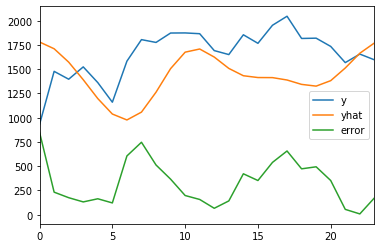

In [100]:
from sklearn.metrics import mean_absolute_error
predictions=forecast.merge(models[0]["data"])[['ds','yhat','y']]
predictions["error"]=np.absolute(predictions["y"] - predictions["yhat"])
predictions[["y","yhat","error"]].plot()
print(mean_absolute_error(y_true=predictions["y"], y_pred=predictions["yhat"]))

Import File: DE_Großhandelspreise_201506010000_201706012359_1.csv 
Import File: DE_Großhandelspreise_201706010000_201906012359_1.csv 


TypeError: <lambda>() got an unexpected keyword argument 'axis'